Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')


In [2]:
import pandas as pd

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [3]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [4]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

### Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' and the sale price was more than 100 thousand and less than 2 million.

In [49]:
def subset_data(dataframe, building_class_category, minimum_price, maximum_price):
    
    """ A function to subset NYC property sales data (stored as pandas DataFrame) to a specific "BUILDING_CLASS_CATEGORY". 
    The data are subset within a minimum and maximum "SALE_PRICE", also defined by user.
    Additionally, "SALE_DATE" is converted from object type to pandas DateTime for ease of time-based data slicing.
    Returns a new pandas DataFrame
    """
    
    assert type(dataframe) == type(pd.DataFrame()), "dataframe must be a pandas DataFrame. Please edit your parameters."
    assert type(building_class_category) == type(str()), "building_class_category must be a string. Please modify your parameters."
    assert isinstance(minimum_price, (int, float)), "minimum_price must be an integer or float value. Please edit your input value."
    assert isinstance(maximum_price, (int, float)), "maximum_price must be an integer or float value. Please modify your input value."

    dataframe_subset = dataframe[dataframe["BUILDING_CLASS_CATEGORY"] == building_class_category]
    
    results = dataframe_subset[(dataframe_subset["SALE_PRICE"] > minimum_price) & (dataframe_subset["SALE_PRICE"] < maximum_price)].copy()
    
    results["SALE_DATE"] = pd.to_datetime(results["SALE_DATE"], infer_datetime_format=True)
    
    return results

In [50]:
subset = subset_data(df, "01 ONE FAMILY DWELLINGS", 100000, 2000000)

print(subset.shape)

subset.head()

(3151, 21)


BOROUGH NEIGHBORHOOD  BUILDING_CLASS_CATEGORY TAX_CLASS_AT_PRESENT  BLOCK  \
44        3        OTHER  01 ONE FAMILY DWELLINGS                    1   5495   
61        4        OTHER  01 ONE FAMILY DWELLINGS                    1   7918   
78        2        OTHER  01 ONE FAMILY DWELLINGS                    1   4210   
108       3        OTHER  01 ONE FAMILY DWELLINGS                    1   5212   
111       3        OTHER  01 ONE FAMILY DWELLINGS                    1   7930   

     LOT  EASE-MENT BUILDING_CLASS_AT_PRESENT               ADDRESS  \
44   801        NaN                        A9      4832 BAY PARKWAY   
61    72        NaN                        A1    80-23 232ND STREET   
78    19        NaN                        A1  1260 RHINELANDER AVE   
108   69        NaN                        A1         469 E 25TH ST   
111  121        NaN                        A5      5521 WHITTY LANE   

    APARTMENT_NUMBER  ...  RESIDENTIAL_UNITS  COMMERCIAL_UNITS  TOTAL_UNITS  \
44               NaN  ...                1.0               0.0          1.0   
61               NaN  ...                1.0               0.0          1.0   
78               NaN  ...                1.0               0.0          1.0   
108              NaN  ...                1.0               0.0          1.0   
111              NaN  ...                1.0               0.0          1.0   

     LAND_SQUARE_FEET GROSS_SQUARE_FEET  YEAR_BUILT  \
44              6,800            1325.0      1930.0   
61              4,000            2001.0      1940.0   
78              3,500            2043.0      1925.0   
108             4,000            2680.0      1899.0   
111             1,710            1872.0      1940.0   

     TAX_CLASS_AT_TIME_OF_SALE  BUILDING_CLASS_AT_TIME_OF_SALE SALE_PRICE  \
44                           1                              A9     550000   
61                           1                              A1     200000   
78                           1                              A1     810000   
108                          1                              A1     125000   
111                          1                              A5     620000   

     SALE_DATE  
44  2019-01-01  
61  2019-01-01  
78  2019-01-02  
108 2019-01-02  
111 2019-01-02  

[5 rows x 21 columns]

### Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [88]:
train = subset[subset["SALE_DATE"].dt.month < 4]
test = subset[subset["SALE_DATE"].dt.month == 4]

### Do one-hot encoding of categorical features.

In [89]:
train.describe(include="object")

BOROUGH NEIGHBORHOOD  BUILDING_CLASS_CATEGORY TAX_CLASS_AT_PRESENT  \
count     2507         2507                     2507                 2507   
unique       5            7                        1                    2   
top          4        OTHER  01 ONE FAMILY DWELLINGS                    1   
freq      1204         2360                     2507                 2476   

       BUILDING_CLASS_AT_PRESENT          ADDRESS APARTMENT_NUMBER  \
count                       2507             2507                1   
unique                        13             2497                1   
top                           A1  33 BAILEY PLACE              RP.   
freq                         919                2                1   

       LAND_SQUARE_FEET BUILDING_CLASS_AT_TIME_OF_SALE  
count              2507                           2507  
unique              887                             11  
top               4,000                             A1  
freq                234                            919

In [90]:
train.describe(include="number")

BLOCK          LOT  EASE-MENT      ZIP_CODE  RESIDENTIAL_UNITS  \
count   2507.000000  2507.000000        0.0   2507.000000        2507.000000   
mean    6758.303949    75.778221        NaN  10993.398484           0.987635   
std     3975.909029   157.531138        NaN    494.291462           0.110532   
min       21.000000     1.000000        NaN  10301.000000           0.000000   
25%     3837.500000    21.000000        NaN  10314.000000           1.000000   
50%     6022.000000    42.000000        NaN  11234.000000           1.000000   
75%     9888.500000    70.000000        NaN  11413.000000           1.000000   
max    16350.000000  2720.000000        NaN  11697.000000           1.000000   

       COMMERCIAL_UNITS  TOTAL_UNITS  GROSS_SQUARE_FEET   YEAR_BUILT  \
count       2507.000000  2507.000000        2507.000000  2507.000000   
mean           0.016354     1.003989        1473.744715  1944.766653   
std            0.129966     0.171794         599.217635    27.059337   
min            0.000000     0.000000           0.000000  1890.000000   
25%            0.000000     1.000000        1144.000000  1925.000000   
50%            0.000000     1.000000        1368.000000  1940.000000   
75%            0.000000     1.000000        1683.000000  1960.000000   
max            2.000000     3.000000        7875.000000  2018.000000   

       TAX_CLASS_AT_TIME_OF_SALE    SALE_PRICE  
count                     2507.0  2.507000e+03  
mean                         1.0  6.215737e+05  
std                          0.0  2.916072e+05  
min                          1.0  1.040000e+05  
25%                          1.0  4.405000e+05  
50%                          1.0  5.600000e+05  
75%                          1.0  7.500000e+05  
max                          1.0  1.955000e+06

In [100]:
def convert_columns_from_float_to_int(dataframe):
    data = dataframe.copy()
    data["YEAR_BUILT"] = data["YEAR_BUILT"].astype(int)
    data["GROSS_SQUARE_FEET"] = data["GROSS_SQUARE_FEET"].astype(int)
    return data

In [102]:
train = convert_columns_from_float_to_int(train)
test = convert_columns_from_float_to_int(test)

In [103]:
target = "SALE_PRICE"

high_cardinality =  ["ADDRESS", "LAND_SQUARE_FEET", "BUILDING_CLASS_CATEGORY", "APARTMENT_NUMBER", "SALE_DATE", "EASE-MENT", "BLOCK", "LOT", "ZIP_CODE"]


features = train.columns.drop([target] + high_cardinality)


In [104]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [105]:
subset.shape, X_train.shape, X_test.shape

((3151, 21), (2507, 11), (644, 11))

In [106]:
import category_encoders as ce

encoder = ce.OneHotEncoder(use_cat_names=True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

X_train.shape, X_test.shape

((2507, 44), (644, 44))

### Do feature selection with SelectKBest

In [118]:
# TODO: How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error



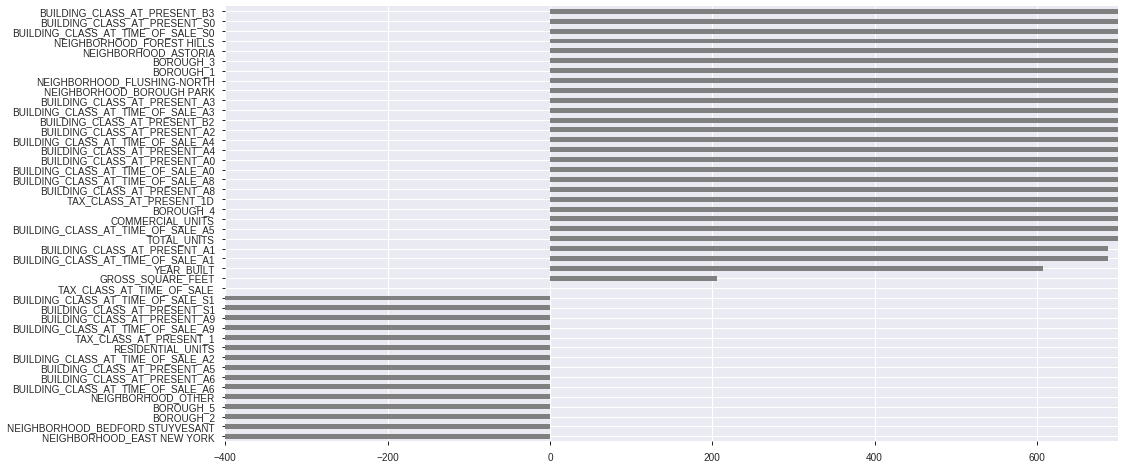

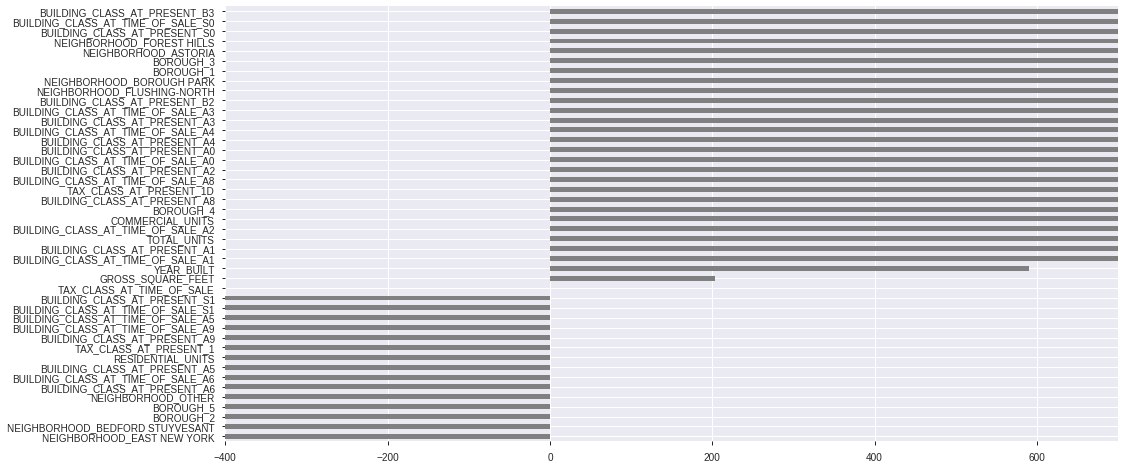

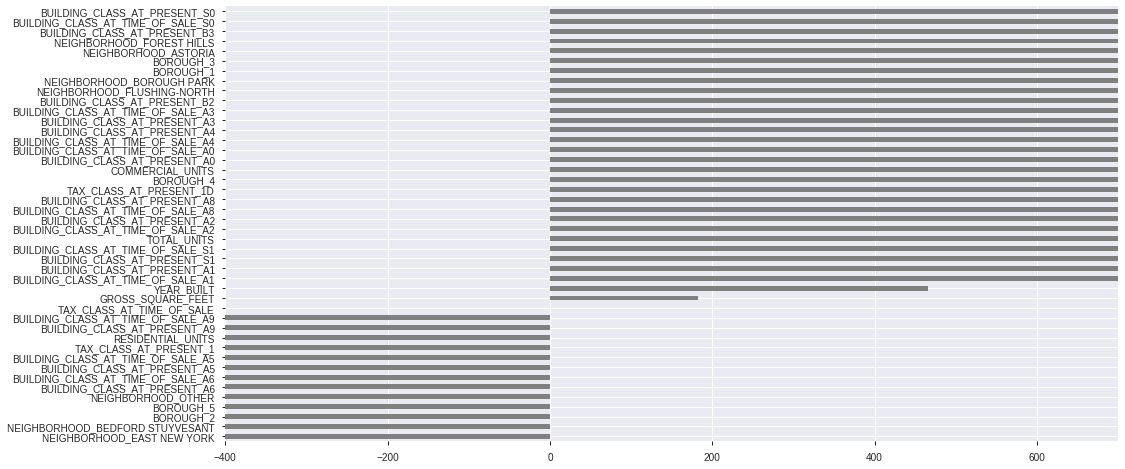

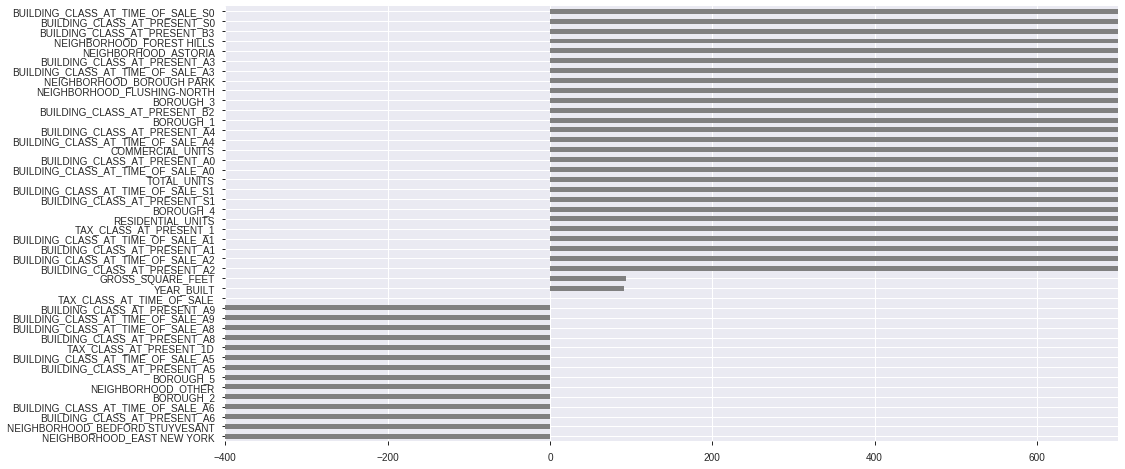

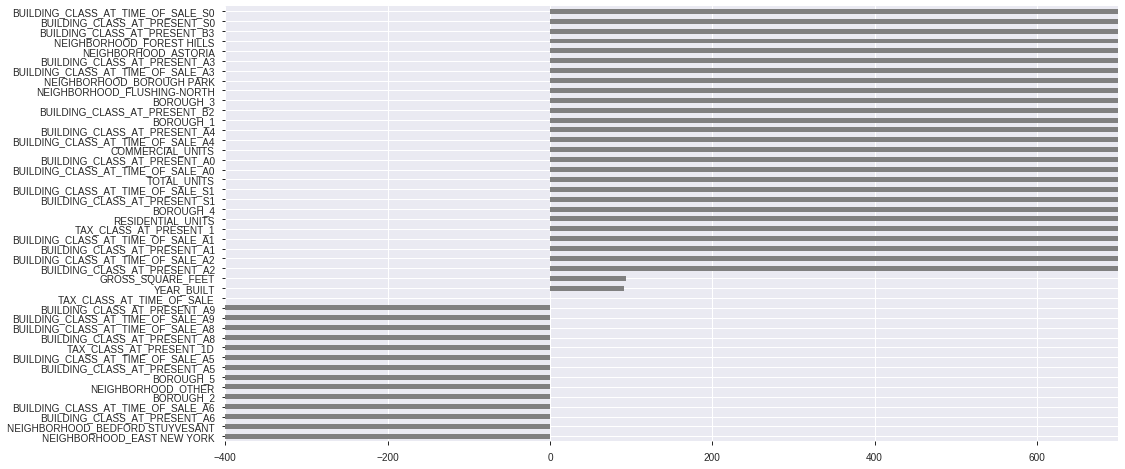

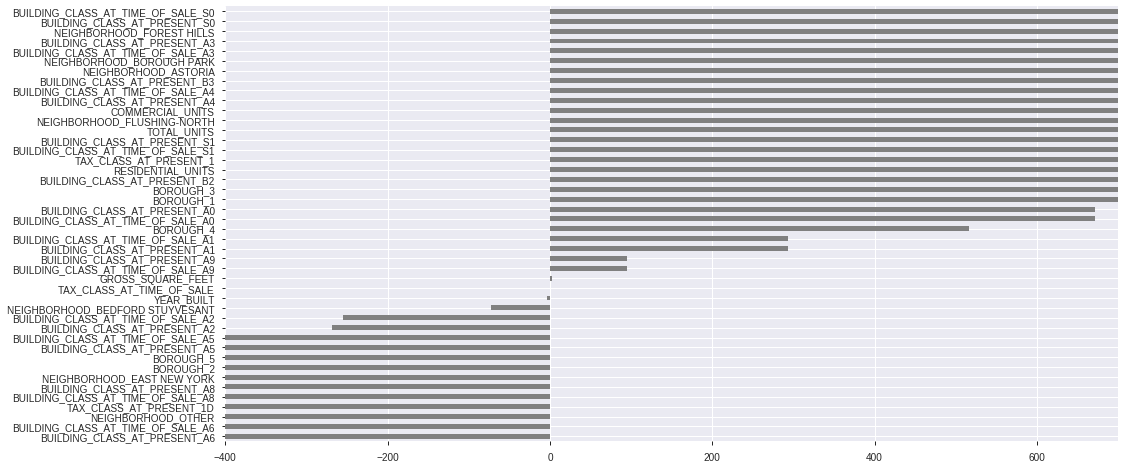

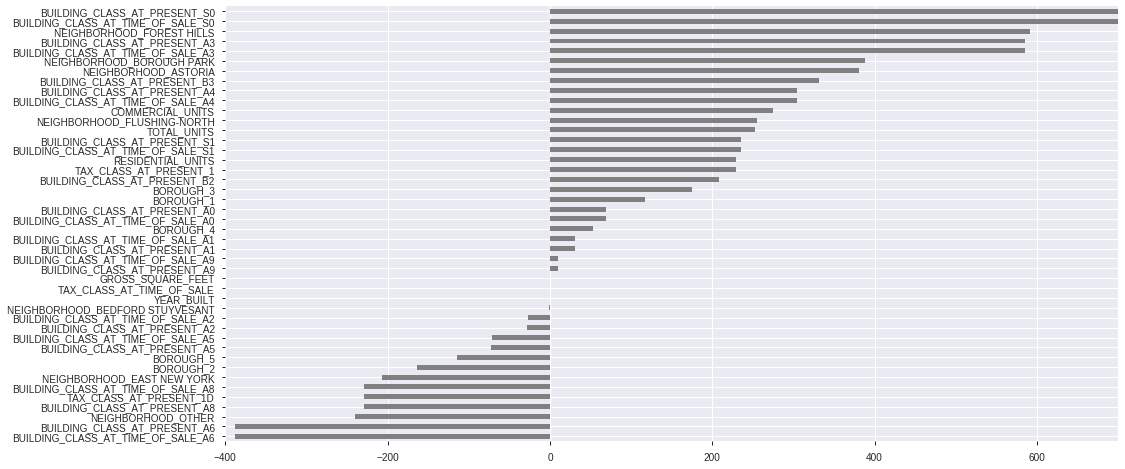

In [117]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,700)
    plt.show()

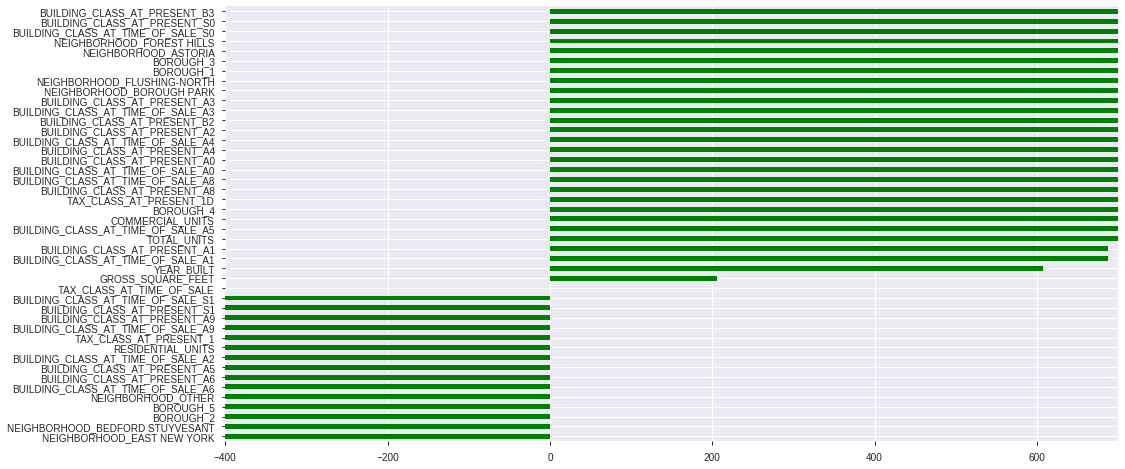

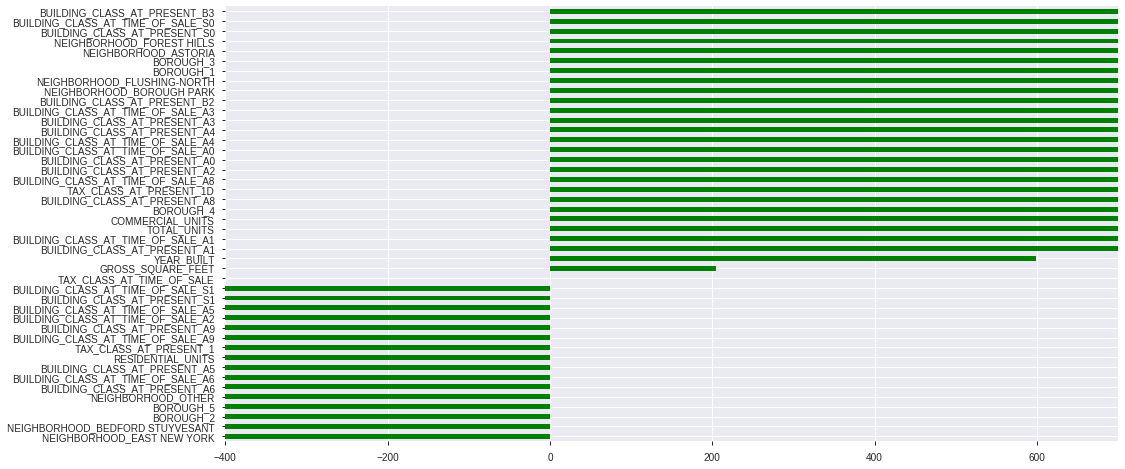

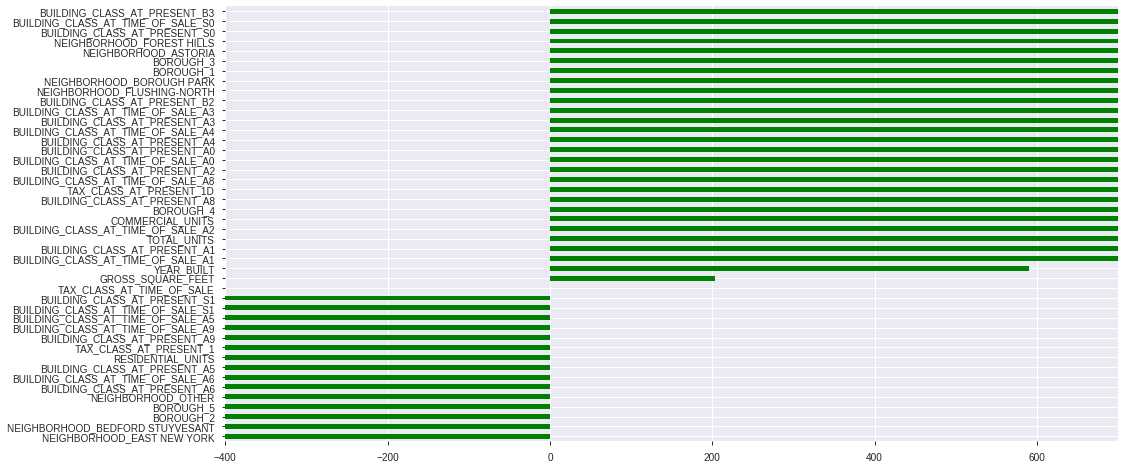

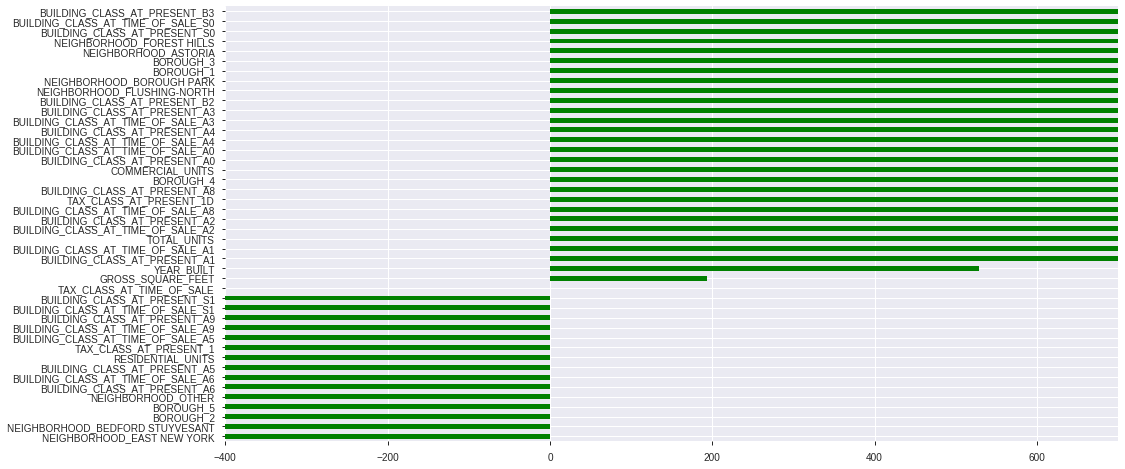

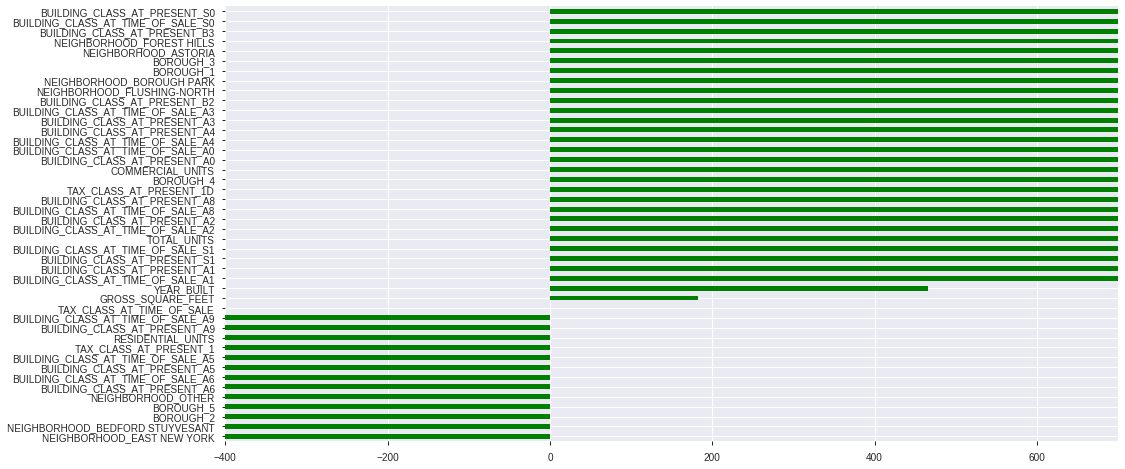

In [123]:
for alpha in [0.001, 0.005, 0.01, 0.05, 0.1]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='green')
    plt.xlim(-400,700)
    plt.show()

In [121]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    model = Ridge(alpha=0.05, normalize=True)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')


1 features
Test Mean Absolute Error: $184,017 

2 features
Test Mean Absolute Error: $183,079 

3 features
Test Mean Absolute Error: $183,057 

4 features
Test Mean Absolute Error: $183,664 

5 features
Test Mean Absolute Error: $178,439 

6 features
Test Mean Absolute Error: $177,148 

7 features
Test Mean Absolute Error: $176,797 

8 features
Test Mean Absolute Error: $175,786 

9 features
Test Mean Absolute Error: $174,887 

10 features
Test Mean Absolute Error: $174,901 

11 features
Test Mean Absolute Error: $175,565 

12 features
Test Mean Absolute Error: $175,797 

13 features
Test Mean Absolute Error: $175,815 

14 features
Test Mean Absolute Error: $175,534 

15 features
Test Mean Absolute Error: $175,507 

16 features
Test Mean Absolute Error: $175,372 

17 features
Test Mean Absolute Error: $175,369 

18 features
Test Mean Absolute Error: $172,371 

19 features
Test Mean Absolute Error: $172,387 

20 features
Test Mean Absolute Error: $172,551 

21 features
Test Mean Absolut

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x

Test Mean Absolute Error: $171,842 

36 features
Test Mean Absolute Error: $171,326 

37 features
Test Mean Absolute Error: $171,306 

38 features
Test Mean Absolute Error: $171,333 

39 features
Test Mean Absolute Error: $171,158 

40 features
Test Mean Absolute Error: $171,123 

41 features
Test Mean Absolute Error: $171,121 

42 features
Test Mean Absolute Error: $171,122 

43 features
Test Mean Absolute Error: $171,573 

44 features
Test Mean Absolute Error: $171,573 



/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x

In [124]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=18)

X_train_selected = selector.fit_transform(X_train, y_train)


selected_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print("Features selected")
for name in selected_names:
  print(name)

print("\n")

print("Features not selected")
for name in unselected_names:
  print(name)

Features selected
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A6
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A6


Features not selected
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1

/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/alex/anaconda3/envs/geoprocessing/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x

In [130]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

guess = y_train.mean()
print(f'Value for baseline guessing method of NYC sing-family home sale prices: ${train["SALE_PRICE"].mean():.2f}\n')
y_pred = [guess] * len(y_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_train, y_pred)
print(f'Train R^2 Score: {r2:.2f}\n')

y_pred = [guess] * len(y_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')

Value for baseline guessing method of NYC sing-family home sale prices: $621573.74

Train Root Mean Square Error: $291549.06
Train Mean Absolute Error: $214721.53
Train R^2 Score: 0.00

Test Root Mean Square Error: $298711.63
Test Mean Absolute Error: $211564.20
Test R^2 Score: -0.01


In [320]:
model = Ridge(alpha=0.05, normalize=True)
y_train = train[target] #target="SALE_PRICE"
X_train = X_train[selected_names]
X_test = X_test[selected_names]
y_train = train[target]

model.fit(X_train, y_train)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [321]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, selected_names)
print(coefficients.to_string())

Intercept 361449.20625183533
BOROUGH_3                            116623.712665
BOROUGH_2                           -159697.650200
BOROUGH_5                            -97584.071072
NEIGHBORHOOD_OTHER                    52875.593645
NEIGHBORHOOD_FLUSHING-NORTH          276129.679499
NEIGHBORHOOD_FOREST HILLS            488765.962758
NEIGHBORHOOD_BOROUGH PARK            272347.112744
BUILDING_CLASS_AT_PRESENT_A5         -21004.711887
BUILDING_CLASS_AT_PRESENT_A3         101282.799215
BUILDING_CLASS_AT_PRESENT_S1        -120010.329078
BUILDING_CLASS_AT_PRESENT_A6         -80255.399953
COMMERCIAL_UNITS                     340116.977921
TOTAL_UNITS                          -57587.530021
GROSS_SQUARE_FEET                       193.358065
BUILDING_CLASS_AT_TIME_OF_SALE_A5    -15124.197309
BUILDING_CLASS_AT_TIME_OF_SALE_A3    101282.799215
BUILDING_CLASS_AT_TIME_OF_SALE_S1   -120010.329078
BUILDING_CLASS_AT_TIME_OF_SALE_A6    -80255.399953


### Get mean absolute error for the test set.

In [322]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_train, y_pred)
print(f'Train R^2 Score: {r2:.2f}\n')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')

Train Root Mean Square Error: $233058.23
Train Mean Absolute Error: $169420.14
Train R^2 Score: 0.36

Train Root Mean Square Error: $243579.18
Test Mean Absolute Error: $172370.92
Test R^2 Score: 0.33


### Instead of Ridge, try LinearRegression. Depending on how many features you select, your errors will probably blow up! 💥

In [323]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


encoder = ce.OneHotEncoder(use_cat_names=True)

X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [324]:
for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')


1 features
Test Mean Absolute Error: $183,641 

2 features
Test Mean Absolute Error: $182,569 

3 features
Test Mean Absolute Error: $182,569 

4 features
Test Mean Absolute Error: $183,441 

5 features
Test Mean Absolute Error: $178,041 

6 features
Test Mean Absolute Error: $176,532 

7 features
Test Mean Absolute Error: $176,282 

8 features
Test Mean Absolute Error: $175,735 

9 features
Test Mean Absolute Error: $174,907 

10 features
Test Mean Absolute Error: $174,906 

11 features
Test Mean Absolute Error: $175,923 

12 features
Test Mean Absolute Error: $176,191 

13 features
Test Mean Absolute Error: $176,184 

14 features
Test Mean Absolute Error: $175,921 

15 features
Test Mean Absolute Error: $175,921 

16 features
Test Mean Absolute Error: $175,767 

17 features
Test Mean Absolute Error: $175,767 

18 features
Test Mean Absolute Error: $172,183 

19 features
Test Mean Absolute Error: $172,178 

20 features
Test Mean Absolute Error: $172,178 

21 features
Test Mean Absolut

Error blows up at forty features

In [325]:
model = LinearRegression(n_jobs=-1)
y_train = train[target] #target="SALE_PRICE"
X_train = X_train[selected_names]
X_test = X_test[selected_names]
y_train = train[target]

model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [326]:
print('Intercept', model.intercept_)
coefficients = pd.Series(model.coef_, selected_names)
print(coefficients.to_string())

Intercept 340569.49582521507
BOROUGH_3                            122711.405921
BOROUGH_2                           -170996.430177
BOROUGH_5                           -103214.163400
NEIGHBORHOOD_OTHER                   107490.642943
NEIGHBORHOOD_FLUSHING-NORTH          343027.298936
NEIGHBORHOOD_FOREST HILLS            566683.521834
NEIGHBORHOOD_BOROUGH PARK            332134.850513
BUILDING_CLASS_AT_PRESENT_A5        -100478.891393
BUILDING_CLASS_AT_PRESENT_A3          90386.634075
BUILDING_CLASS_AT_PRESENT_S1        -242757.897057
BUILDING_CLASS_AT_PRESENT_A6         -74184.415139
COMMERCIAL_UNITS                     624037.057963
TOTAL_UNITS                         -112176.118782
GROSS_SQUARE_FEET                       208.027583
BUILDING_CLASS_AT_TIME_OF_SALE_A5     67034.598059
BUILDING_CLASS_AT_TIME_OF_SALE_A3     90386.634075
BUILDING_CLASS_AT_TIME_OF_SALE_S1   -242757.897057
BUILDING_CLASS_AT_TIME_OF_SALE_A6    -74184.415139


In [327]:
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_train, y_pred)
print(f'Train R^2 Score: {r2:.2f}\n')

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Train Root Mean Square Error: ${rmse:.2f}')
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'Test R^2 Score: {r2:.2f}')

Train Root Mean Square Error: $232559.12
Train Mean Absolute Error: $169099.47
Train R^2 Score: 0.36

Train Root Mean Square Error: $243300.47
Test Mean Absolute Error: $172182.54
Test R^2 Score: 0.33


Results are comparable to Ridge regression

In [165]:
import geopandas as gpd
zip_codes_gdf = gpd.read_file("https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/ny_new_york_zip_codes_geo.min.json")
zip_codes_gdf.head()

STATEFP10 ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10    ALAND10  \
0        36     12205  3612205        B5   G6350          S   40906445   
1        36     12009  3612009        B5   G6350          S  135241924   
2        36     14804  3614804        B5   G6350          S  144718714   
3        36     14836  3614836        B5   G6350          S   77612958   
4        36     14536  3614536        B5   G6350          S   47193482   

   AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0    243508  +42.7187855  -073.8292399         N   
1   2168637  +42.6975663  -074.0355422         N   
2    232123  +42.3172588  -077.8479358         N   
3    131305  +42.5429182  -077.8781933         N   
4    425175  +42.5439751  -078.0836709         N   

                                            geometry  
0  POLYGON ((-73.87052 42.75123, -73.86861 42.756...  
1  POLYGON ((-74.10891 42.65300, -74.10889 42.653...  
2  POLYGON ((-77.92747 42.34775, -77.92632 42.347...  
3  MULTIPOLYGON (((-77.95599 42.47433, -77.95600 ...  
4  POLYGON ((-78.05030 42.53850, -78.05024 42.538...

In [172]:
zip_codes_gdf["ZCTA5CE10"] = zip_codes_gdf["ZCTA5CE10"].astype(int)

In [181]:
zip_codes_gdf["ZCTA5CE10"].value_counts()

14305    1
13162    1
11577    1
13626    1
11579    1
        ..
14894    1
12847    1
12849    1
14898    1
12302    1
Name: ZCTA5CE10, Length: 1794, dtype: int64

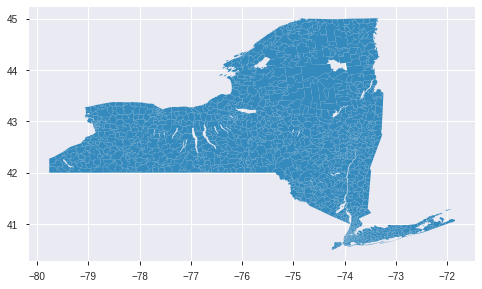

In [166]:
zip_codes_gdf.plot()

In [182]:
subset["ZCTA5CE10"] = subset["ZIP_CODE"].astype("int")

In [184]:
subset["ZCTA5CE10"].value_counts()

10306    127
10312    124
10314    113
11434    100
11234     90
        ... 
11102      1
10030      1
11217      1
11220      1
11211      1
Name: ZCTA5CE10, Length: 125, dtype: int64

In [185]:
merged = zip_codes_gdf.merge(subset, on="ZCTA5CE10")

In [179]:
merged.head()

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10  ALAND10  \
0        36      10464  3610464        B5   G6350          S  9070627   
1        36      10464  3610464        B5   G6350          S  9070627   
2        36      10464  3610464        B5   G6350          S  9070627   
3        36      10464  3610464        B5   G6350          S  9070627   
4        36      10464  3610464        B5   G6350          S  9070627   

   AWATER10   INTPTLAT10    INTPTLON10  ... RESIDENTIAL_UNITS  \
0    236605  +40.8677868  -073.7999204  ...               1.0   
1    236605  +40.8677868  -073.7999204  ...               1.0   
2    236605  +40.8677868  -073.7999204  ...               1.0   
3    236605  +40.8677868  -073.7999204  ...               1.0   
4    236605  +40.8677868  -073.7999204  ...               1.0   

  COMMERCIAL_UNITS TOTAL_UNITS LAND_SQUARE_FEET GROSS_SQUARE_FEET YEAR_BUILT  \
0              0.0         1.0            2,466             761.0     1940.0   
1              0.0         1.0            5,229            1080.0     1925.0   
2              0.0         1.0            2,500             756.0     1940.0   
3              0.0         1.0            5,000            1779.0     1901.0   
4              0.0         1.0            2,500             740.0     1925.0   

   TAX_CLASS_AT_TIME_OF_SALE  BUILDING_CLASS_AT_TIME_OF_SALE  SALE_PRICE  \
0                          1                              A2      375000   
1                          1                              A2      438000   
2                          1                              A2      380000   
3                          1                              A1      679000   
4                          1                              A2      210000   

   SALE_DATE  
0 2019-01-28  
1 2019-01-30  
2 2019-02-22  
3 2019-03-21  
4 2019-03-22  

[5 rows x 33 columns]

In [186]:
merged.shape

(3151, 33)

In [194]:
merged.groupby("ZCTA5CE10")["SALE_PRICE"].mean().reset_index()

ZCTA5CE10    SALE_PRICE
0        10030  1.800000e+06
1        10301  6.323767e+05
2        10302  3.941374e+05
3        10303  3.813523e+05
4        10304  5.743424e+05
..         ...           ...
120      11691  5.043359e+05
121      11692  3.088026e+05
122      11693  3.252500e+05
123      11694  8.422037e+05
124      11697  3.748111e+05

[125 rows x 2 columns]

In [196]:
zip_code_mean_sale_price_gdf = zip_codes_gdf.merge(merged.groupby("ZCTA5CE10")["SALE_PRICE"].mean().reset_index())

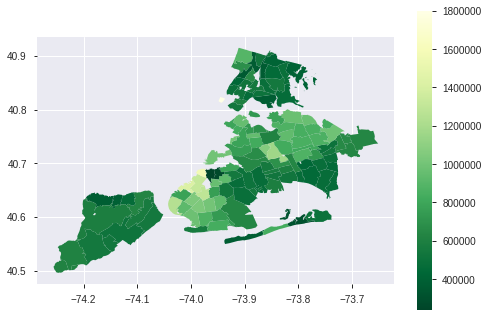

In [202]:
zip_code_mean_sale_price_gdf.plot("SALE_PRICE", cmap='YlGn_r', legend=True)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
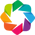

In [207]:
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import cartopy
import cartopy.feature as cf
from geoviews import dim, opts
from geoviews import opts
from cartopy import crs as ccrs
import geoviews.tile_sources as gts
gv.extension('bokeh')

In [228]:
from bokeh.models import HoverTool

In [239]:
zip_code_mean_sale_price_gdf

STATEFP10  ZCTA5CE10  GEOID10 CLASSFP10 MTFCC10 FUNCSTAT10   ALAND10  \
0          36      10464  3610464        B5   G6350          S   9070627   
1          36      10470  3610470        B5   G6350          S   3689950   
2          36      10455  3610455        B5   G6350          S   1844518   
3          36      10473  3610473        B5   G6350          S   5645604   
4          36      11234  3611234        B5   G6350          S  19547849   
..        ...        ...      ...       ...     ...        ...       ...   
120        36      11102  3611102        B5   G6350          S   2092161   
121        36      11693  3611693        B5   G6350          S   2582599   
122        36      11369  3611369        B5   G6350          S   2765090   
123        36      11363  3611363        B5   G6350          S   2249596   
124        36      10308  3610308        B5   G6350          S   5110510   

     AWATER10   INTPTLAT10    INTPTLON10 PARTFLG10  \
0      236605  +40.8677868  -073.7999204         N   
1        3918  +40.8895273  -073.8726596         N   
2           0  +40.8147100  -073.9085917         N   
3       13868  +40.8186904  -073.8584741         N   
4     2143727  +40.6050798  -073.9117206         N   
..        ...          ...           ...       ...   
120      7099  +40.7728839  -073.9262952         N   
121         0  +40.5906918  -073.8097488         N   
122         0  +40.7633359  -073.8724429         N   
123         0  +40.7726163  -073.7465255         N   
124     12006  +40.5518840  -074.1476456         N   

                                              geometry     SALE_PRICE  
0    MULTIPOLYGON (((-73.78619 40.87389, -73.78605 ...  407888.888889  
1    POLYGON ((-73.86563 40.90209, -73.86527 40.901...  526666.666667  
2    POLYGON ((-73.91712 40.81751, -73.91821 40.817...  600000.000000  
3    POLYGON ((-73.88433 40.82261, -73.88444 40.822...  375358.117647  
4    POLYGON ((-73.92965 40.58344, -73.93111 40.582...  640050.922222  
..                                                 ...            ...  
120  POLYGON ((-73.92425 40.76472, -73.92484 40.765...  800000.000000  
121  MULTIPOLYGON (((-73.80514 40.58821, -73.80430 ...  325250.000000  
122  POLYGON ((-73.88268 40.76161, -73.88301 40.763...  693631.677419  
123  POLYGON ((-73.73785 40.77488, -73.73687 40.774...  836857.800000  
124  POLYGON ((-74.14048 40.55418, -74.13978 40.554...  534986.039216  

[125 rows x 13 columns]

In [272]:
zip_code_mean_sale_price_gdf["SALE_PRICE"] = zip_code_mean_sale_price_gdf["SALE_PRICE"].astype(int)

In [275]:
from bokeh.models import PrintfTickFormatter


In [303]:
hover = HoverTool(tooltips = [("ZIP Code","@ZCTA5CE10"),("Sale Price", "$@SALE_PRICE")])
formatter = PrintfTickFormatter(format='%.0f')
plot_opts = dict(colorbar=True, colorbar_opts={'formatter': formatter})
sweet_map = gts.CartoDark * gv.Polygons(zip_code_mean_sale_price_gdf, vdims=['SALE_PRICE', "ZCTA5CE10"]).opts(padding=0.05, colorbar_opts={'formatter': formatter}, toolbar="left", height=500, width=600, tools=[hover], xaxis=None, yaxis=None, colorbar=True, cmap="cividis", title="Single Family Home Average Sale Price, January to May 2019")

In [305]:
sweet_map

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (SALE_PRICE,ZCTA5CE10)

In [306]:
gv.save(sweet_map, "average-single-family-home-sale-price.html")
gv.save(sweet_map, "average-single-family-home-sale-price.png")